# CHI 2023 

## Improving Human Compliance with Algorithmic Advice via Collaboration

In [499]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import json
from tqdm import tqdm
import ast
from scipy.stats import chi2_contingency

In [500]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

### Cleaning

In [508]:
data = pd.read_csv("data.csv")
data = data[34:]

In [509]:
data.shape

(170, 288)

In [510]:
data["ResponseId"].to_csv("new_ids", index = False)

In [511]:
filtered = data[["id", "ResponseId",  "total_bonus" ]]

filtered.shape

(170, 3)

In [512]:
filtered = filtered.dropna(axis = "index", subset = "total_bonus")[2:]
bonus_subtracted = filtered["total_bonus"].astype(float)-1.4
filtered["total_bonus - 1.5"] = bonus_subtracted

In [513]:
filtered.to_csv("filtered", index = False)

In [514]:
data = data[data["Finished"] == "True"]

In [515]:
data = data.dropna(axis = "index", subset = "round_6_elapsed_time")

In [516]:
data.shape

(70, 288)

In [292]:
# to see the columns
data[:2]

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,id,consent,Q86_First Click,Q86_Last Click,Q86_Page Submit,Q86_Click Count,Q87_First Click,Q87_Last Click,Q87_Page Submit,Q87_Click Count,Q88_First Click,Q88_Last Click,Q88_Page Submit,Q88_Click Count,Q89_First Click,Q89_Last Click,Q89_Page Submit,Q89_Click Count,Q99_First Click,Q99_Last Click,Q99_Page Submit,Q99_Click Count,Q90_First Click,Q90_Last Click,Q90_Page Submit,Q90_Click Count,Q72,Q77,Q78,Q79,Q127_First Click,Q127_Last Click,Q127_Page Submit,Q127_Click Count,Q128_First Click,Q128_Last Click,Q128_Page Submit,Q128_Click Count,Q129_First Click,Q129_Last Click,Q129_Page Submit,Q129_Click Count,t11_First Click,t11_Last Click,t11_Page Submit,t11_Click Count,t12_First Click,t12_Last Click,t12_Page Submit,t12_Click Count,t13_First Click,t13_Last Click,t13_Page Submit,t13_Click Count,t21_First Click,t21_Last Click,t21_Page Submit,t21_Click Count,t22_First Click,t22_Last Click,t22_Page Submit,t22_Click Count,Q157_First Click,Q157_Last Click,Q157_Page Submit,Q157_Click Count,Q222,Q158_First Click,Q158_Last Click,Q158_Page Submit,Q158_Click Count,Q184,Q191,Q251_First Click,Q251_Last Click,Q251_Page Submit,Q251_Click Count,Q223,Q258_First Click,Q258_Last Click,Q258_Page Submit,Q258_Click Count,Q218,Q7,Q8,Q261_First Click,Q261_Last Click,Q261_Page Submit,Q261_Click Count,Q224,Q268_First Click,Q268_Last Click,Q268_Page Submit,Q268_Click Count,Q220,Q356,Q357,Q271_First Click,Q271_Last Click,Q271_Page Submit,Q271_Click Count,Q225,Q276_First Click,Q276_Last Click,Q276_Page Submit,Q276_Click Count,t63_First Click,t63_Last Click,t63_Page Submit,t63_Click Count,Q221,Q109_First Click,Q109_Last Click,Q109_Page Submit,Q109_Click Count,post_diff,post_tip_sentiment,post_tipviews_1,post_tipviews_2,post_tipviews_3,post_tipviews_4,post_tipviews_5,post_barriers_1,post_barriers_2,post_barriers_3,post_barriers_4,post_barriers_5,post_barriers_6,post_barriers_explai,post_style_change,post_style_process,post_style_decide,post_advice_normal,post_good_normal,post_best_normal,Q92_First Click,Q92_Last Click,Q92_Page Submit,Q92_Click Count,post_pre_disruption,post_saw_tip_disrupt,post_advice_disrupt,post_good_disrupt,post_best_disrupt,post_source_of_tip,post_source_switch,Q112_First Click,Q112_Last Click,Q112_Page Submit,Q112_Click Count,post_gender,post_gender_20_TEXT,post_age,post_edu,post_job,post_feedback,round_0_elapsed_time,round_0_config_id,round_0_actions,round_0_score,round_0_states,round_1_elapsed_time,round_1_actions,round_1_score,round_1_states,round_2_elapsed_time,round_2_actions,round_2_score,round_2_states,round_3_elapsed_time,round_3_actions,round_3_score,round_3_states,round_0_reward,round_1_reward,round_2_reward,round_3_reward,min_pay,max_pay,pay1,pay2,pay3,pay4,round_1_bonus,round_2_bonus,round_3_bonus,total_bonus,failedtraining,paymax,paymin,paymid,base_pay,chat_0,chat_1,chat_2,chat_3,tip_num,explanation_num,excluded,Create New Field or Choose From Dropdown...,round_0_tip,round_1_tip,round_2_tip,round_3_tip,round_4_tip,round_5_tip,round_6_tip,round_1_config_id,round_1_unit_reward,round_1_fin_tick,round_1_t1,round_1_t2,round_1_t3,round_1_t4,round_2_config_id,round_2_unit_reward,round_2_fin_tick,round_2_t1,round_2_t2,round_2_t3,round_2_t4,round_3_config_id,round_3_unit_reward,round_3_fin_tick,round_3_t1,round_3_t2,round_3_t3,round_3_t4,round_4_config_id,round_4_unit_reward,round_4_fin_tick,round_4_t1,round_4_t2,round_4_t3,round_4_t4,round_4_actions,round_4_states,round_4_score,round_4_reward,round_4_bonus,round_4_elapsed_time,round_5_config_id,round_5_unit_reward,round_5_fin_tick,round_5_t1,round_5_t2,round_5_t3,round_5_t4,round_5_actions,round_5_states,round_5_score,round_5_reward,round_5_bonus,round_5_elapsed_time,round_6_config_id,round_6_unit_reward,round_6_fin_tick,round_6_t1,round_6_t2,round_6_t3,rou

### Grouping

In [517]:
conditions = [np.logical_and((data["tip_num"] == "1").values,  (data["explanation_num"] == "1").values), 
              np.logical_and((data["tip_num"] == "2").values,  (data["explanation_num"] == "1").values),
              np.logical_and((data["tip_num"] == "1").values,  (data["explanation_num"] == "2").values),
              np.logical_and((data["tip_num"] == "2").values,  (data["explanation_num"] == "2").values)
             ]
values = ["once_low_confidence", "twice_low_confidence", "once_high_confidence", "twice_high_confidence"]
alldata = data.copy()
alldata["group"] = np.select(conditions, values)

In [518]:
once_low_confidence = data[data["tip_num"] == "1"]
once_low_confidence = once_low_confidence[once_low_confidence["explanation_num"] == "1"]

In [519]:
twice_low_confidence = data[data["tip_num"] == "2"]
twice_low_confidence = twice_low_confidence[twice_low_confidence["explanation_num"] == "1"]

In [520]:
once_high_confidence = data[data["tip_num"] == "1"]
once_high_confidence = once_high_confidence[once_high_confidence["explanation_num"] == "2"]

In [521]:
twice_high_confidence = data[data["tip_num"] == "2"]
twice_high_confidence = twice_high_confidence[twice_high_confidence["explanation_num"] == "2"]

In [522]:
once_low_confidence.shape

(17, 288)

In [523]:
twice_low_confidence.shape

(15, 288)

In [524]:
once_high_confidence.shape

(22, 288)

In [525]:
twice_high_confidence.shape

(16, 288)

In [526]:
data = [once_low_confidence, twice_low_confidence, once_high_confidence, twice_high_confidence]

### Score Diff

In [596]:
def draw_time_distribution(num, num_round, legend):
    temp_series = pd.to_numeric(data[num]["round_" + str(num_round) + "_elapsed_time"]).values
    sns.distplot(temp_series, hist=False, rug=True, label = legend, ax = ax, hist_kws={'rwidth':50});

/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

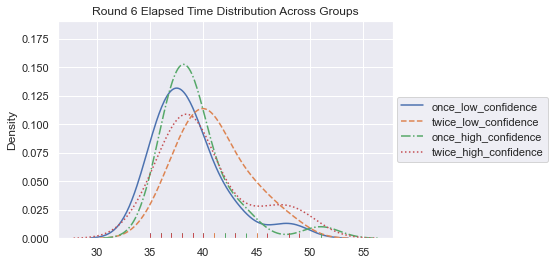

In [597]:
fig, ax = plt.subplots()
draw_time_distribution(0, 6, "once_low_confidence")
draw_time_distribution(1, 6, "twice_low_confidence")
draw_time_distribution(2, 6, "once_high_confidence")
draw_time_distribution(3, 6, "twice_high_confidence")

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Round 6 Elapsed Time Distribution Across Groups")
plt.show()


/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

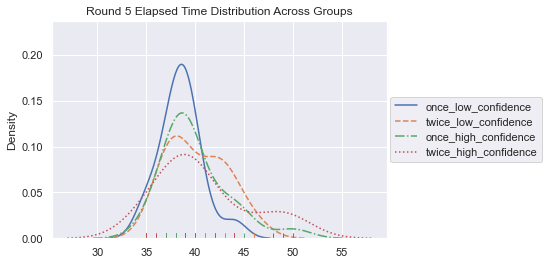

In [637]:
fig, ax = plt.subplots()
draw_time_distribution(0, 5, "once_low_confidence")
draw_time_distribution(1, 5, "twice_low_confidence")
draw_time_distribution(2, 5, "once_high_confidence")
draw_time_distribution(3, 5, "twice_high_confidence")

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Round 5 Elapsed Time Distribution Across Groups")
plt.show()


/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

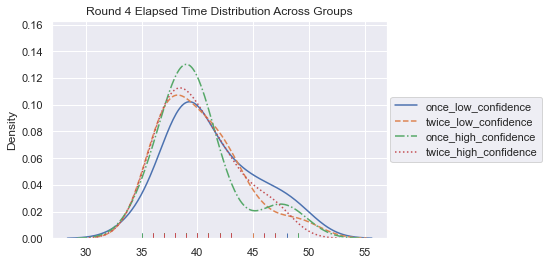

In [638]:
fig, ax = plt.subplots()
draw_time_distribution(0, 4, "once_low_confidence")
draw_time_distribution(1, 4, "twice_low_confidence")
draw_time_distribution(2, 4, "once_high_confidence")
draw_time_distribution(3, 4, "twice_high_confidence")

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Round 4 Elapsed Time Distribution Across Groups")
plt.show()


/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarni

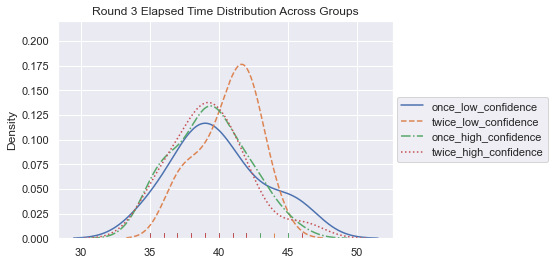

In [598]:
fig, ax = plt.subplots()
draw_time_distribution(0, 3, "once_low_confidence")
draw_time_distribution(1, 3, "twice_low_confidence")
draw_time_distribution(2, 3, "once_high_confidence")
draw_time_distribution(3, 3, "twice_high_confidence")

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Round 3 Elapsed Time Distribution Across Groups")
plt.show()

In [603]:
def draw_intuitiveness_distribution(num, legend):
    temp_series = data[num]["post_barriers_1"]
    conditions = [temp_series == "Strongly disagree", temp_series == "Somewhat disagree", temp_series == "Neither agree or disagree", temp_series == "Somewhat agree", temp_series == "Strongly agree"]
    values = [1, 2, 3, 4, 5]
    temp_series = np.select(conditions, values)
#     print(temp_series)
    sns.distplot(temp_series, hist=False, label = legend, hist_kws={'rwidth':50});
    return temp_series


/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

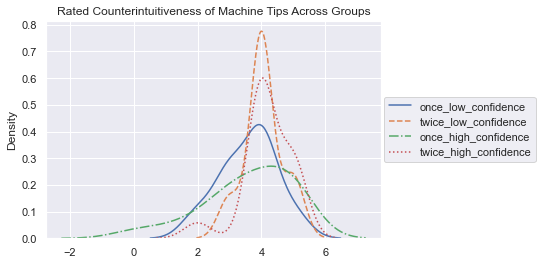

In [630]:
fig, ax = plt.subplots()
counterin_score1 = np.mean(draw_intuitiveness_distribution(0, "once_low_confidence"))
counterin_score2 = np.mean(draw_intuitiveness_distribution(1, "twice_low_confidence"))
counterin_score3 = np.mean(draw_intuitiveness_distribution(2, "once_high_confidence"))
counterin_score4 = np.mean(draw_intuitiveness_distribution(3, "twice_high_confidence"))

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Rated Counterintuitiveness of Machine Tips Across Groups")
plt.show()

/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

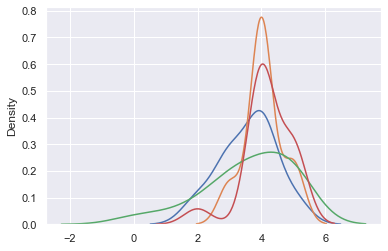

In [634]:
counterin_score1 = np.std(draw_intuitiveness_distribution(0, "once_low_confidence"))
counterin_score2 = np.std(draw_intuitiveness_distribution(1, "twice_low_confidence"))
counterin_score3 = np.std(draw_intuitiveness_distribution(2, "once_high_confidence"))
counterin_score4 = np.std(draw_intuitiveness_distribution(3, "twice_high_confidence"))


In [635]:
counter_scores = [[counterin_score3, counterin_score1], [counterin_score4, counterin_score2]]

In [636]:
counter_scores

[[1.3704375846983032, 0.8442764761416073],
 [0.7261843774138906, 0.573488351136175]]

In [624]:
chi2, p_value, dof, ex = chi2_contingency(counter_scores)

In [625]:
once_twice_p

1.0

### Score Change

In [438]:
pd.to_numeric(data[0]["round_" + str(3) + "_elapsed_time"]).values

array([35, 40, 42, 38, 42, 38, 39, 45, 45, 39, 37, 38, 46, 41, 40, 39, 35])

In [536]:
def draw_time_series(num, legend):
    performance = []
    for round_num in range(3,7):
        temp_series = np.mean(pd.to_numeric(data[num]["round_" + str(round_num) + "_elapsed_time"]).values)
        performance.append(temp_series)
    sns.lineplot(["round3", "round4", "round5", "round6"], performance, label = legend,  linewidth=3)
    return performance

In [537]:
sns.set_theme(style="darkgrid")


/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

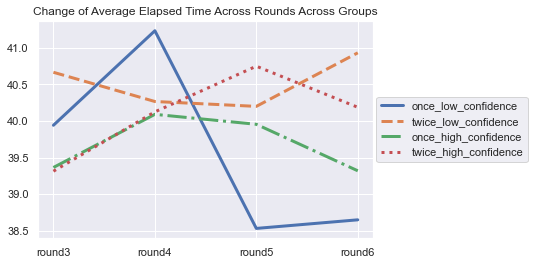

In [554]:
fig, ax = plt.subplots()
performance1 = draw_time_series(0, "once_low_confidence")
performance2 = draw_time_series(1, "twice_low_confidence")
performance3 = draw_time_series(2, "once_high_confidence")
performance4 = draw_time_series(3, "twice_high_confidence")
ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Change of Average Elapsed Time Across Rounds Across Groups")
plt.show()

In [555]:
# round significance test

In [556]:
def return_time_series(num, round_num):
    temp_series = pd.to_numeric(data[num]["round_" + str(round_num) + "_elapsed_time"]).values
    return sum(temp_series)

In [557]:
def chi2_performacne_test(round_num):
    low_conf = [return_time_series(0, round_num), return_time_series(1, round_num)]
    high_conf = [return_time_series(2, round_num), return_time_series(3, round_num)]
    once = [return_time_series(0, round_num), return_time_series(2, round_num)]
    twice = [return_time_series(1, round_num), return_time_series(3, round_num)]
    chi2, conf_p, dof, ex = chi2_contingency([low_conf, high_conf])
    chi2, once_twice_p, dof, ex = chi2_contingency([once, twice])
    return conf_p, once_twice_p

In [558]:
ps = []
for round_num in range(3, 7):
    ps.append(chi2_performacne_test(round_num)[0])

In [559]:
ps

[0.006124183468249409,
 0.02907143650282312,
 0.005336331179998331,
 0.0031464185712226592]

### Willingness to follow

In [560]:
yes = "Yes, I intend to follow the tip in this round"
maybe = "Maybe, I'll keep it in mind and see"
no = "No, I don't plan to follow the suggested tip this round"

In [561]:
# range -1 to 1
def willingness_scale(dataframe, num):
    questions = ["Q222", "Q223", "Q224", "Q225"]
    return sum(dataframe[questions[num]] == yes) - sum(dataframe[questions[num]] == no) / len(dataframe[questions[num]])

In [562]:
willingness_scale(once_low_confidence, 2)

7.9411764705882355

In [552]:
def draw_willingness_time_series(num, legend):
    willingness = []
    for round_num in range(4):
        willingness.append(willingness_scale(data[num], round_num))
    sns.lineplot(["round3", "round4", "round5", "round6"], willingness, label = legend, linewidth=3)
    return willingness

/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

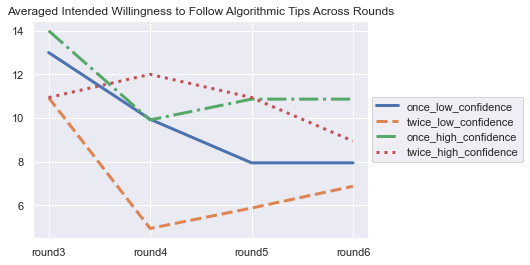

In [563]:
fig, ax = plt.subplots()
new_df = pd.DataFrame()
twice_low_confidence1 = draw_willingness_time_series(0, "once_low_confidence")
twice_low_confidence1 = draw_willingness_time_series(1, "twice_low_confidence")
once_high_confidence1 = draw_willingness_time_series(2, "once_high_confidence")
twice_high_confidence1 = draw_willingness_time_series(3, "twice_high_confidence")

new_df["round"] = ["round3", "round4", "round5", "round6"]
new_df["twice_low_confidence"] = twice_low_confidence1
new_df["twice_low_confidence1"] = twice_low_confidence1
new_df["once_high_confidence1"] = once_high_confidence1
new_df["twice_high_confidence1"] = twice_high_confidence1

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Averaged Intended Willingness to Follow Algorithmic Tips Across Rounds")
plt.show()

In [492]:
# Significance test

### Suggested Tip Change

In [564]:
def suggested_tip(dataframe, num):
    questions = ["Q184", "Q7", "Q356"]
    return np.mean(dataframe[questions[num]].astype(int))

In [565]:
suggested_tip(once_low_confidence, 2)

1.7647058823529411

In [566]:
def draw_suggested_tip_time_series(num, legend):
    tips = []
    for round_num in range(3):
        tips.append(suggested_tip(data[num], round_num))
    sns.lineplot(["round3", "round4", "round5"], tips, label = legend, linewidth=3)

/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

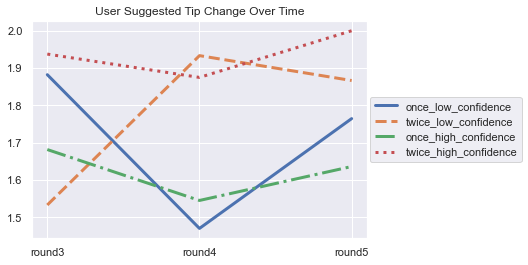

In [602]:
fig, ax = plt.subplots()
draw_suggested_tip_time_series(0, "once_low_confidence")
draw_suggested_tip_time_series(1, "twice_low_confidence")
draw_suggested_tip_time_series(2, "once_high_confidence")
draw_suggested_tip_time_series(3, "twice_high_confidence")

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("User Suggested Tip Change Over Time")
plt.show()

### Peer Helpfulness Change

In [568]:
very = "It's very helpful"
barely = "It barely helps"
not_help = "It's not helpful at all"
not_sure = "I am not sure"

In [569]:
# range -1 to 1
def peer_helpful_scale(dataframe, num):
    questions = ["Q218", "Q220", "Q221"]
    return (sum(dataframe[questions[num]] == very) - sum(dataframe[questions[num]] == not_help)) / len(dataframe[[questions[num]]])

In [570]:
peer_helpful_scale(once_low_confidence, 2)

0.23529411764705882

In [571]:
def draw_helpfulness_time_series(num, legend):
    willingness = []
    for round_num in range(3):
        willingness.append(peer_helpful_scale(data[num], round_num))
    sns.lineplot(["round4", "round5", "round6"], willingness, label = legend, ci = "sd", err_style="bars", linewidth=3)

/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

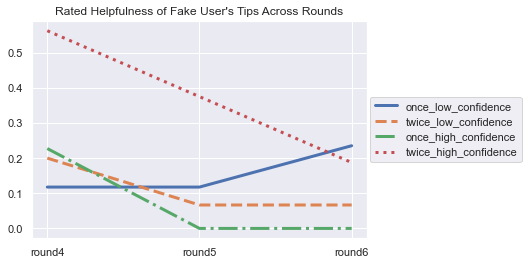

In [572]:
fig, ax = plt.subplots()
draw_helpfulness_time_series(0, "once_low_confidence")
draw_helpfulness_time_series(1, "twice_low_confidence")
draw_helpfulness_time_series(2, "once_high_confidence")
draw_helpfulness_time_series(3, "twice_high_confidence")

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Rated Helpfulness of Fake User's Tips Across Rounds")
plt.show()

### Actual Assigned Server Number

In [422]:
# extract server cook num
def extrac_server_cook_num(alldata):
# 0~chef, 1~sou_chef, 2~server
# 99 ~ available, 100 ~ finished
    final36 = pd.DataFrame()
    dat = alldata.loc[:,["ResponseId", "round_1_states", "round_2_states", "round_3_states", "round_4_states", "round_5_states", "round_6_states"]]
    dat = dat.reset_index()
    for round in ["round_3_states", "round_4_states", "round_5_states", "round_6_states"]:
      out = pd.DataFrame()
      ID = dat["ResponseId"]
      for kim in tqdm(np.arange(len(ID))):
        zzx = pd.DataFrame(json.loads(dat[round][kim]))

        sou_chef_order = [state[0]["order_index"] for state in zzx["worker_states"]]
        sou_chef_task = [state[0]["task"] for state in zzx["worker_states"]]
        sou_chef_left_ticks = [state[0]["ticks"] for state in zzx["worker_states"]]

        server_order = [state[1]["order_index"] for state in zzx["worker_states"]]
        server_task = [state[1]["task"] for state in zzx["worker_states"]]
        server_left_ticks = [state[1]["ticks"] for state in zzx["worker_states"]]

        ticks = np.arange(len(sou_chef_order))

        # t01, order 0, task 1, 12 in total 
        t00 = ["available"] * len(ticks)
        t01 = ["unavailable"] * len(ticks)
        t02 = ["unavailable"] * len(ticks)

        t10 = ["available"] * len(ticks)
        t11 = ["unavailable"] * len(ticks)
        t12 = ["unavailable"] * len(ticks)

        t20 = ["available"] * len(ticks)
        t21 = ["unavailable"] * len(ticks)
        t22 = ["unavailable"] * len(ticks)

        t30 = ["available"] * len(ticks)
        t31 = ["unavailable"] * len(ticks)
        t32 = ["unavailable"] * len(ticks)

        matrix = [[t00, t01, t02], [t10, t11, t12], [t20, t21, t22], [t30, t31, t32]]

        i = 0
        for i in np.arange(len(ticks)):

          order_sou_chef = sou_chef_order[i]
          task_sou_chef = sou_chef_task[i]
          if order_sou_chef != None and task_sou_chef != None:
            matrix[order_sou_chef][task_sou_chef][i] = "sou_chef"

            for jisoo in np.arange(2):
              if task_sou_chef == jisoo and sou_chef_left_ticks[i] == 1:
                new1 = matrix[order_sou_chef][jisoo+1][:i+1]
                new2 = ["available"]*(len(ticks) - i - 1)
                matrix[order_sou_chef][jisoo+1] = new1 + new2


            for mmy in np.arange(3):
              if task_sou_chef == mmy and sou_chef_left_ticks[i] == 1:
                new1 = matrix[order_sou_chef][mmy][:i+1]
                new2 = ["finished"]*(len(ticks) - i - 1)
                matrix[order_sou_chef][mmy] = new1 + new2


          order_server = server_order[i]
          task_server = server_task[i]
          if order_server != None and task_server != None:
            matrix[order_server][task_server][i] = "server"

            for jisoo in np.arange(2):
              if task_server == jisoo and server_left_ticks[i] == 1:
                new1 = matrix[order_server][jisoo+1][:i+1]
                new2 = ["available"]*(len(ticks) - i - 1)
                matrix[order_server][jisoo+1] = new1 + new2

            for mmy in np.arange(3):
              if task_server == mmy and server_left_ticks[i] == 1:
                new1 = matrix[order_server][mmy][:i+1]
                new2 = ["finished"]*(len(ticks) - i - 1)
                matrix[order_server][mmy] = new1 + new2


        player = pd.DataFrame()
        player["ID"] = [ID[kim]] * len(ticks)
        player["round"] = [round] * len(ticks)
        player["sou_chef_order"] = sou_chef_order
        player["sou_chef_task"] = sou_chef_task
        player["sou_chef_left_ticks"] = sou_chef_left_ticks
        player["server_order"] = server_order
        player["server_task"] = server_task
        player["server_left_ticks"] = server_left_ticks
        player["ticks"] = ticks
        player["order0_task0"] = matrix[0][0]
        player["order0_task1"] = matrix[0][1]
        player["order0_task2"] = matrix[0][2]
        player["order1_task0"] = matrix[1][0]
        player["order1_task1"] = matrix[1][1]
        player["order1_task2"] = matrix[1][2]
        player["order2_task0"] = matrix[2][0]
        player["order2_task1"] = matrix[2][1]
        player["order2_task2"] = matrix[2][2]
        player["order3_task0"] = matrix[3][0]
        player["order3_task1"] = matrix[3][1]
        player["order3_task2"] = matrix[3][2]

        out = pd.concat([out, player])
      final36 = pd.concat([final36, out])

    final36 = final36[["ID", "order1_task1", "order2_task1", "order3_task1", "round"]]
    # final36

    def server_cook_num_aggregate(df):
        server_cook_num = 0
        columns = ["order1_task1", "order2_task1", "order3_task1"]
        for column in columns:
            if "server" in df[column].values:
                server_cook_num += 1
        return server_cook_num

    server_cook_num = final36.groupby(by = ["ID", "round"]).apply(server_cook_num_aggregate)
    server_cooking = server_cook_num.index.to_frame(index=False)
    server_cooking["server_cook_num"] = server_cook_num.values
    double_grouped = server_cooking.groupby(by = "round").apply(np.mean)
    return double_grouped["server_cook_num"].values

100%|████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 404.73it/s]
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
100%|████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.96it/s]
/Users/stephen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWa

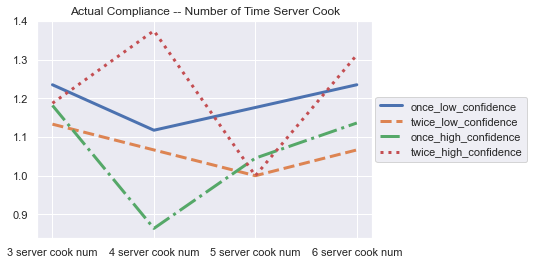

In [573]:
fig, ax = plt.subplots()

sns.lineplot(x = ["3 server cook num", "4 server cook num", "5 server cook num", "6 server cook num"], y = extrac_server_cook_num(data[0]), label = "once_low_confidence", linewidth=3)
sns.lineplot(x = ["3 server cook num", "4 server cook num", "5 server cook num", "6 server cook num"], y = extrac_server_cook_num(data[1]), label = "twice_low_confidence", linewidth=3)
sns.lineplot(x = ["3 server cook num", "4 server cook num", "5 server cook num", "6 server cook num"], y = extrac_server_cook_num(data[2]), label = "once_high_confidence", linewidth=3)
sns.lineplot(x = ["3 server cook num", "4 server cook num", "5 server cook num", "6 server cook num"], y = extrac_server_cook_num(data[3]), label = "twice_high_confidence", linewidth=3)

ax.lines[0].set_linestyle("solid")
ax.lines[1].set_linestyle("dashed")
ax.lines[2].set_linestyle("-.")
ax.lines[3].set_linestyle(":")

plt.legend(loc=(1.01,.35))
plt.title("Actual Compliance -- Number of Time Server Cook")
plt.show()